# Inicio

In [ ]:
!pip install category_encoders
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Para test y train, creo dos features nuevas: el día de la semana y el rango de las horas.

In [ ]:
columnas = ["attack_time", "watcher_country", "watcher_as_name", "attacker_country", "attacker_as_name", "attack_type", "attacker_ip_enum"]
X_test = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/test.parq", columns = columnas)
X_test = X_test.drop_duplicates(subset = ["attacker_ip_enum"])
X_test = X_test.sort_values(by = "attacker_ip_enum")
X_test

,attack_time,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,attacker_ip_enum
21502,2023-08-05 01:06:05+00:00,US,GOOGLE,KH,ANGKOR DATA COMMUNICATION,http:bruteforce,5
191,2023-07-30 07:48:36+00:00,LU,PONYNET,CA,OVH SAS,ssh:bruteforce,7
665517,2023-08-24 22:34:25+00:00,DE,ENTEGA Medianet GmbH,DE,Vodafone GmbH,http:scan,21
72758,2023-07-31 15:06:25+00:00,US,A2HOSTING,IN,Threesa Infoway Pvt.Ltd.,http:spam,29
37390,2023-07-31 12:51:27+00:00,GB,DIGITALOCEAN-ASN,CZ,"Seznam.cz, a.s.",http:spam,33
...,...,...,...,...,...,...,...
17869691,2023-08-02 19:20:11+00:00,US,CONTABO,BR,GOOGLE,unknown:unknown,199947
17977618,2023-08-29 01:54:37+00:00,DE,Hetzner Online GmbH,ZA,Afrihost,ssh:bruteforce,199949
17862033,2023-08-02 01:09:27+00:00,US,GOOGLE-CLOUD-PLATFORM,GB,Constantine Cybersecurity Ltd.,http:spam,199962
17857346,2023-08-03 00:41:02+00:00,HK,AMAZON-02,BH,Kalaam Telecom Bahrain B.S.C.,http:spam,199964


In [ ]:
X_test_ip = X_test[["attacker_ip_enum"]]
X_test_ip

,attacker_ip_enum
21502,5
191,7
665517,21
72758,29
37390,33
...,...
17869691,199947
17977618,199949
17862033,199962
17857346,199964


In [ ]:
X_test["hour"] = X_test["attack_time"].dt.hour
X_test["hour_range"] = pd.cut(X_test["hour"], bins = [0, 6, 12, 18, 23], labels = ["(0-6)","(6-12)", "(12-18)", "(18-0)"])
X_test["day"] = X_test["attack_time"].dt.day_name()
X_test = X_test.drop(["hour", "attack_time", "attacker_ip_enum"], axis = 1)
X_test

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,hour_range,day
21502,US,GOOGLE,KH,ANGKOR DATA COMMUNICATION,http:bruteforce,(0-6),Saturday
191,LU,PONYNET,CA,OVH SAS,ssh:bruteforce,(6-12),Sunday
665517,DE,ENTEGA Medianet GmbH,DE,Vodafone GmbH,http:scan,(18-0),Thursday
72758,US,A2HOSTING,IN,Threesa Infoway Pvt.Ltd.,http:spam,(12-18),Monday
37390,GB,DIGITALOCEAN-ASN,CZ,"Seznam.cz, a.s.",http:spam,(6-12),Monday
...,...,...,...,...,...,...,...
17869691,US,CONTABO,BR,GOOGLE,unknown:unknown,(18-0),Wednesday
17977618,DE,Hetzner Online GmbH,ZA,Afrihost,ssh:bruteforce,(0-6),Tuesday
17862033,US,GOOGLE-CLOUD-PLATFORM,GB,Constantine Cybersecurity Ltd.,http:spam,(0-6),Wednesday
17857346,HK,AMAZON-02,BH,Kalaam Telecom Bahrain B.S.C.,http:spam,NaN,Thursday


In [ ]:
columnas = ["attack_time", "watcher_country", "watcher_as_name", "attacker_country", "attacker_as_name", "attack_type", "attacker_ip_enum", "label"]
train = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/train.parq", columns = columnas)
train

,attack_time,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,attacker_ip_enum,label
0,2023-07-31 07:17:51+00:00,DE,Host Europe GmbH,TR,Murat Aktas,http:exploit,6466,0
1,2023-07-31 07:17:51+00:00,DE,Host Europe GmbH,TR,Murat Aktas,http:spam,6466,0
2,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:bruteforce,4637,0
3,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:spam,4637,0
4,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:exploit,4637,0
...,...,...,...,...,...,...,...,...
61629680,2023-08-24 21:14:52+00:00,DE,ENTEGA Medianet GmbH,DE,Vodafone GmbH,http:scan,190784,0
61629681,2023-08-24 21:14:46+00:00,US,NAMECHEAP-NET,US,WOW,http:scan,193446,0
61629682,2023-08-24 21:14:46+00:00,US,NAMECHEAP-NET,US,WOW,http:spam,193446,0
61629683,2023-08-24 21:14:46+00:00,US,NAMECHEAP-NET,US,WOW,http:spam,193446,0


Como voy a splitear el train para conseguir el set de validación, dropeo los duplicados para que no queden separados en diferentes sets y termine validando con la data aprendida en el entrenamiento.

In [ ]:
train = train.drop_duplicates()
train = train.copy()
train

,attack_time,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,attacker_ip_enum,label
0,2023-07-31 07:17:51+00:00,DE,Host Europe GmbH,TR,Murat Aktas,http:exploit,6466,0
1,2023-07-31 07:17:51+00:00,DE,Host Europe GmbH,TR,Murat Aktas,http:spam,6466,0
2,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:bruteforce,4637,0
3,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:spam,4637,0
4,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:exploit,4637,0
...,...,...,...,...,...,...,...,...
61629671,2023-08-24 21:14:59+00:00,US,INMOTION,US,ATT-INTERNET4,http:bruteforce,191439,0
61629673,2023-08-24 21:14:59+00:00,US,INMOTION,US,ATT-INTERNET4,http:scan,191439,0
61629674,2023-08-24 21:14:59+00:00,US,INMOTION,US,ATT-INTERNET4,http:exploit,191439,0
61629681,2023-08-24 21:14:46+00:00,US,NAMECHEAP-NET,US,WOW,http:scan,193446,0


In [ ]:
train["hour"] = train["attack_time"].dt.hour
train["hour_range"] = pd.cut(train["hour"], bins = [0, 6, 12, 18, 23], labels = ["(0-6)","(6-12)", "(12-18)", "(18-0)"])
train["day"] = train["attack_time"].dt.day_name()
train = train.drop(["hour", "attack_time"], axis = 1)
train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,attacker_ip_enum,label,hour_range,day
0,DE,Host Europe GmbH,TR,Murat Aktas,http:exploit,6466,0,(6-12),Monday
1,DE,Host Europe GmbH,TR,Murat Aktas,http:spam,6466,0,(6-12),Monday
2,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:bruteforce,4637,0,(6-12),Monday
3,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:spam,4637,0,(6-12),Monday
4,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:exploit,4637,0,(6-12),Monday
...,...,...,...,...,...,...,...,...,...
61629671,US,INMOTION,US,ATT-INTERNET4,http:bruteforce,191439,0,(18-0),Thursday
61629673,US,INMOTION,US,ATT-INTERNET4,http:scan,191439,0,(18-0),Thursday
61629674,US,INMOTION,US,ATT-INTERNET4,http:exploit,191439,0,(18-0),Thursday
61629681,US,NAMECHEAP-NET,US,WOW,http:scan,193446,0,(18-0),Thursday


# División de Train y Validation

¿Cómo conviene obtener el dataset para validar? Conviene splitear los IPs únicos para que estén todos en el set de test o el de validation, y que no queden divididos en ambos.

In [ ]:
train_set, validation_set = train_test_split(train["attacker_ip_enum"].unique(), test_size = 0.2, random_state = 18)

X_train = train[train["attacker_ip_enum"].isin(train_set)].drop("attacker_ip_enum", axis = 1)
X_validation = train[train["attacker_ip_enum"].isin(validation_set)].drop(["attacker_ip_enum", "label"], axis = 1)
y_validation = train[train["attacker_ip_enum"].isin(validation_set)]["label"]

In [ ]:
label_zero = X_train.loc[X_train["label"] == 0]
label_one = X_train.loc[X_train["label"] == 1]

label_zero = resample(label_zero, replace = False, n_samples = len(label_one), random_state = 18)

X_train = pd.concat([label_zero, label_one])
y_train = X_train["label"]
X_train = X_train.drop("label", axis = 1)

In [ ]:
X_train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,hour_range,day
46466580,US,HVC-AS,CN,CT-HangZhou-IDC,http:scan,(6-12),Monday
35466168,DE,ENTEGA Medianet GmbH,DE,1&1 Versatel Deutschland GmbH,http:scan,(0-6),Saturday
32971698,CZ,Datacamp Limited,CN,Chinanet,ssh:bruteforce,(6-12),Monday
14102806,US,GOOGLE-CLOUD-PLATFORM,MD,StarNet Solutii SRL,http:exploit,(12-18),Friday
38449210,DE,ENTEGA Medianet GmbH,DE,Deutsche Telekom AG,http:scan,(6-12),Friday
...,...,...,...,...,...,...,...
61629208,FR,Cyllene Lille Sasu,CA,AS-COLOCROSSING,unknown:unknown,(6-12),Wednesday
61629247,DE,Strato AG,SG,DIGITALOCEAN-ASN,http:spam,(18-0),Thursday
61629250,DE,Strato AG,SG,DIGITALOCEAN-ASN,http:scan,(18-0),Thursday
61629389,DK,One.com A/S,SG,DIGITALOCEAN-ASN,http:scan,(18-0),Thursday


In [ ]:
X_validation

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,hour_range,day
57,TR,Buuldy Bilisim,VN,VIETNAM POSTS AND TELECOMMUNICATIONS GROUP,tcp:scan,(6-12),Monday
66,US,NETWORK-SOLUTIONS-HOSTING,MZ,Telecomunicacoes de Mocambique (TDM),http:scan,(6-12),Monday
67,US,NETWORK-SOLUTIONS-HOSTING,MZ,Telecomunicacoes de Mocambique (TDM),http:spam,(6-12),Monday
68,US,NETWORK-SOLUTIONS-HOSTING,MZ,Telecomunicacoes de Mocambique (TDM),http:bruteforce,(6-12),Monday
82,US,NETWORK-SOLUTIONS-HOSTING,MZ,Telecomunicacoes de Mocambique (TDM),http:exploit,(6-12),Monday
...,...,...,...,...,...,...,...
61629630,US,DIGITALOCEAN-ASN,TN,Tunisie-Telecom,ssh:bruteforce,(18-0),Thursday
61629654,AL,One Albania Sh.a.,CH,M247 Europe SRL,tcp:scan,(18-0),Thursday
61629657,FR,OVH SAS,DE,Host Europe GmbH,http:spam,(18-0),Thursday
61629658,FR,OVH SAS,DE,Host Europe GmbH,http:exploit,(18-0),Thursday


Encodeo todas las columnas con Mean Encoding porque era lo único que me funcionaba en el momento, pero sé que está mal y eso hace que me de un score bajo, ya que el perceptron es un modelo que hace promedios por sí mismo.

# Attacker Country

In [ ]:
encoder = ce.TargetEncoder(cols = ["attacker_country"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)
X_train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,hour_range,day
46466580,US,HVC-AS,0.283736,CT-HangZhou-IDC,http:scan,(6-12),Monday
35466168,DE,ENTEGA Medianet GmbH,0.496312,1&1 Versatel Deutschland GmbH,http:scan,(0-6),Saturday
32971698,CZ,Datacamp Limited,0.283736,Chinanet,ssh:bruteforce,(6-12),Monday
14102806,US,GOOGLE-CLOUD-PLATFORM,0.592226,StarNet Solutii SRL,http:exploit,(12-18),Friday
38449210,DE,ENTEGA Medianet GmbH,0.496312,Deutsche Telekom AG,http:scan,(6-12),Friday
...,...,...,...,...,...,...,...
61629208,FR,Cyllene Lille Sasu,0.740323,AS-COLOCROSSING,unknown:unknown,(6-12),Wednesday
61629247,DE,Strato AG,0.623902,DIGITALOCEAN-ASN,http:spam,(18-0),Thursday
61629250,DE,Strato AG,0.623902,DIGITALOCEAN-ASN,http:scan,(18-0),Thursday
61629389,DK,One.com A/S,0.623902,DIGITALOCEAN-ASN,http:scan,(18-0),Thursday


# Day

In [ ]:
encoder = ce.TargetEncoder(cols = ["day"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)
X_train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,hour_range,day
46466580,US,HVC-AS,0.283736,CT-HangZhou-IDC,http:scan,(6-12),0.502124
35466168,DE,ENTEGA Medianet GmbH,0.496312,1&1 Versatel Deutschland GmbH,http:scan,(0-6),0.521228
32971698,CZ,Datacamp Limited,0.283736,Chinanet,ssh:bruteforce,(6-12),0.502124
14102806,US,GOOGLE-CLOUD-PLATFORM,0.592226,StarNet Solutii SRL,http:exploit,(12-18),0.489329
38449210,DE,ENTEGA Medianet GmbH,0.496312,Deutsche Telekom AG,http:scan,(6-12),0.489329
...,...,...,...,...,...,...,...
61629208,FR,Cyllene Lille Sasu,0.740323,AS-COLOCROSSING,unknown:unknown,(6-12),0.484352
61629247,DE,Strato AG,0.623902,DIGITALOCEAN-ASN,http:spam,(18-0),0.470981
61629250,DE,Strato AG,0.623902,DIGITALOCEAN-ASN,http:scan,(18-0),0.470981
61629389,DK,One.com A/S,0.623902,DIGITALOCEAN-ASN,http:scan,(18-0),0.470981


# Attack Type

In [ ]:
encoder = ce.TargetEncoder(cols = ["attack_type"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)
X_train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,hour_range,day
46466580,US,HVC-AS,0.283736,CT-HangZhou-IDC,0.507015,(6-12),0.502124
35466168,DE,ENTEGA Medianet GmbH,0.496312,1&1 Versatel Deutschland GmbH,0.507015,(0-6),0.521228
32971698,CZ,Datacamp Limited,0.283736,Chinanet,0.529027,(6-12),0.502124
14102806,US,GOOGLE-CLOUD-PLATFORM,0.592226,StarNet Solutii SRL,0.509452,(12-18),0.489329
38449210,DE,ENTEGA Medianet GmbH,0.496312,Deutsche Telekom AG,0.507015,(6-12),0.489329
...,...,...,...,...,...,...,...
61629208,FR,Cyllene Lille Sasu,0.740323,AS-COLOCROSSING,0.323552,(6-12),0.484352
61629247,DE,Strato AG,0.623902,DIGITALOCEAN-ASN,0.520658,(18-0),0.470981
61629250,DE,Strato AG,0.623902,DIGITALOCEAN-ASN,0.507015,(18-0),0.470981
61629389,DK,One.com A/S,0.623902,DIGITALOCEAN-ASN,0.507015,(18-0),0.470981


# Hour Range

In [ ]:
encoder = ce.TargetEncoder(cols = ["hour_range"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)
X_train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,hour_range,day
46466580,US,HVC-AS,0.283736,CT-HangZhou-IDC,0.507015,0.508885,0.502124
35466168,DE,ENTEGA Medianet GmbH,0.496312,1&1 Versatel Deutschland GmbH,0.507015,0.507006,0.521228
32971698,CZ,Datacamp Limited,0.283736,Chinanet,0.529027,0.508885,0.502124
14102806,US,GOOGLE-CLOUD-PLATFORM,0.592226,StarNet Solutii SRL,0.509452,0.490442,0.489329
38449210,DE,ENTEGA Medianet GmbH,0.496312,Deutsche Telekom AG,0.507015,0.508885,0.489329
...,...,...,...,...,...,...,...
61629208,FR,Cyllene Lille Sasu,0.740323,AS-COLOCROSSING,0.323552,0.508885,0.484352
61629247,DE,Strato AG,0.623902,DIGITALOCEAN-ASN,0.520658,0.493588,0.470981
61629250,DE,Strato AG,0.623902,DIGITALOCEAN-ASN,0.507015,0.493588,0.470981
61629389,DK,One.com A/S,0.623902,DIGITALOCEAN-ASN,0.507015,0.493588,0.470981


# Watcher Country

In [ ]:
encoder = ce.TargetEncoder(cols = ["watcher_country"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)
X_train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,hour_range,day
46466580,0.523791,HVC-AS,0.283736,CT-HangZhou-IDC,0.507015,0.508885,0.502124
35466168,0.474117,ENTEGA Medianet GmbH,0.496312,1&1 Versatel Deutschland GmbH,0.507015,0.507006,0.521228
32971698,0.469302,Datacamp Limited,0.283736,Chinanet,0.529027,0.508885,0.502124
14102806,0.523791,GOOGLE-CLOUD-PLATFORM,0.592226,StarNet Solutii SRL,0.509452,0.490442,0.489329
38449210,0.474117,ENTEGA Medianet GmbH,0.496312,Deutsche Telekom AG,0.507015,0.508885,0.489329
...,...,...,...,...,...,...,...
61629208,0.482391,Cyllene Lille Sasu,0.740323,AS-COLOCROSSING,0.323552,0.508885,0.484352
61629247,0.474117,Strato AG,0.623902,DIGITALOCEAN-ASN,0.520658,0.493588,0.470981
61629250,0.474117,Strato AG,0.623902,DIGITALOCEAN-ASN,0.507015,0.493588,0.470981
61629389,0.456091,One.com A/S,0.623902,DIGITALOCEAN-ASN,0.507015,0.493588,0.470981


# Watcher AS Name

In [ ]:
encoder = ce.TargetEncoder(cols = ["watcher_as_name"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)
X_train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,hour_range,day
46466580,0.523791,0.517781,0.283736,CT-HangZhou-IDC,0.507015,0.508885,0.502124
35466168,0.474117,0.163144,0.496312,1&1 Versatel Deutschland GmbH,0.507015,0.507006,0.521228
32971698,0.469302,0.514325,0.283736,Chinanet,0.529027,0.508885,0.502124
14102806,0.523791,0.580582,0.592226,StarNet Solutii SRL,0.509452,0.490442,0.489329
38449210,0.474117,0.163144,0.496312,Deutsche Telekom AG,0.507015,0.508885,0.489329
...,...,...,...,...,...,...,...
61629208,0.482391,0.818031,0.740323,AS-COLOCROSSING,0.323552,0.508885,0.484352
61629247,0.474117,0.604530,0.623902,DIGITALOCEAN-ASN,0.520658,0.493588,0.470981
61629250,0.474117,0.604530,0.623902,DIGITALOCEAN-ASN,0.507015,0.493588,0.470981
61629389,0.456091,0.486383,0.623902,DIGITALOCEAN-ASN,0.507015,0.493588,0.470981


# Attacker AS Name

In [ ]:
encoder = ce.TargetEncoder(cols = ["attacker_as_name"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)
X_train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,hour_range,day
46466580,0.523791,0.517781,0.283736,0.000000,0.507015,0.508885,0.502124
35466168,0.474117,0.163144,0.496312,0.000000,0.507015,0.507006,0.521228
32971698,0.469302,0.514325,0.283736,0.316036,0.529027,0.508885,0.502124
14102806,0.523791,0.580582,0.592226,0.107083,0.509452,0.490442,0.489329
38449210,0.474117,0.163144,0.496312,0.000000,0.507015,0.508885,0.489329
...,...,...,...,...,...,...,...
61629208,0.482391,0.818031,0.740323,0.907707,0.323552,0.508885,0.484352
61629247,0.474117,0.604530,0.623902,0.710814,0.520658,0.493588,0.470981
61629250,0.474117,0.604530,0.623902,0.710814,0.507015,0.493588,0.470981
61629389,0.456091,0.486383,0.623902,0.710814,0.507015,0.493588,0.470981


# Perceptron

In [ ]:
perceptron = Perceptron()

# Grid Search

In [ ]:
# parametros = {
#     "penalty": ["l1", "l2", "elasticnet", None],
#     "max_iter": [100, 500, 1000, 2000],
#     "class_weight": [None, "balanced"]
# }

# grid_search = GridSearchCV(estimator = perceptron, param_grid = parametros, cv = 5, scoring = "f1", verbose = 2)
# grid_search.fit(X_train, y_train)

# hiperparametros = grid_search.best_params_

# perceptron_optimizado = Perceptron(
#     penalty = hiperparametros["penalty"],
#     max_iter = hiperparametros["max_iter"],
#     class_weight = hiperparametros["class_weight"]
# )

# perceptron_optimizado.fit(X_train, y_train)
# y_prediction = perceptron_optimizado.predict(X_validation)

# hiperparametros

In [ ]:
# f1_score(y_validation, y_prediction)

# Random Search

Elijo estos hiperparámetros porque son los que consideré para obtener mejor score en el modelo.

In [ ]:
parametros = {
    "penalty": ["l1", "l2", "elasticnet", None],
    "max_iter": randint(100, 2000),
    "class_weight": [None, "balanced"]
}

random_search = RandomizedSearchCV(estimator = perceptron, param_distributions = parametros, n_iter = 10, cv = 5, scoring = "f1", random_state = 18)
random_search.fit(X_train, y_train)

hiperparametros = random_search.best_params_

perceptron_optimizado = Perceptron(
    penalty = hiperparametros["penalty"],
    max_iter = hiperparametros["max_iter"],
    class_weight = hiperparametros["class_weight"]
)

perceptron_optimizado.fit(X_train, y_train)
y_prediction = perceptron_optimizado.predict(X_validation)

hiperparametros

{'class_weight': None, 'max_iter': 342, 'penalty': 'elasticnet'}

¿Cuál es el mejor score de validación obtenido?

In [ ]:
f1_score(y_validation, y_prediction)

0.6447435973158021

In [ ]:
accuracy_score(y_validation, y_prediction)

0.9772064598944261

In [ ]:
recall_score(y_validation, y_prediction)

0.7891429588273239

In [ ]:
mean_absolute_error(y_validation, y_prediction)

0.022793540105573856

In [ ]:
mean_squared_error(y_validation, y_prediction)

0.022793540105573856

Al predecir con este modelo para test, ¿Cúal es el score obtenido? (Guardar el csv con predicciones para entregarlo después)

In [ ]:
y_prediction = perceptron_optimizado.predict(X_test)
y_prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [ ]:
predictions = pd.DataFrame({"label": y_prediction}).reset_index(drop = True)
X_test_ip = X_test_ip.reset_index(drop = True)

predicciones = pd.concat([X_test_ip, predictions], axis = 1)
predicciones

,attacker_ip_enum,label
0,5,0
1,7,0
2,21,0
3,29,0
4,33,0
...,...,...
49415,199947,0
49416,199949,0
49417,199962,0
49418,199964,0


El score obtenido es: 0.47474

In [ ]:
predicciones.to_csv("/content/drive/MyDrive/Colab Notebooks/predicciones_perceptron_mejor_score.csv", index = False)

https://drive.google.com/file/d/1GUQg_WFZuLhiRsTVDtsYMqm1n_oV-AJ0/view?usp=drive_link

¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

In [ ]:
feature_importance = pd.DataFrame({"feature": X_train.columns, "coefficient": perceptron_optimizado.coef_.ravel()})
feature_importance["coefficient"] = feature_importance["coefficient"].abs()
feature_importance

,feature,coefficient
0,watcher_country,0.867582
1,watcher_as_name,2.450316
2,attacker_country,1.073440
3,attacker_as_name,4.643968
4,attack_type,3.421841
5,hour_range,0.000000
6,day,0.000000


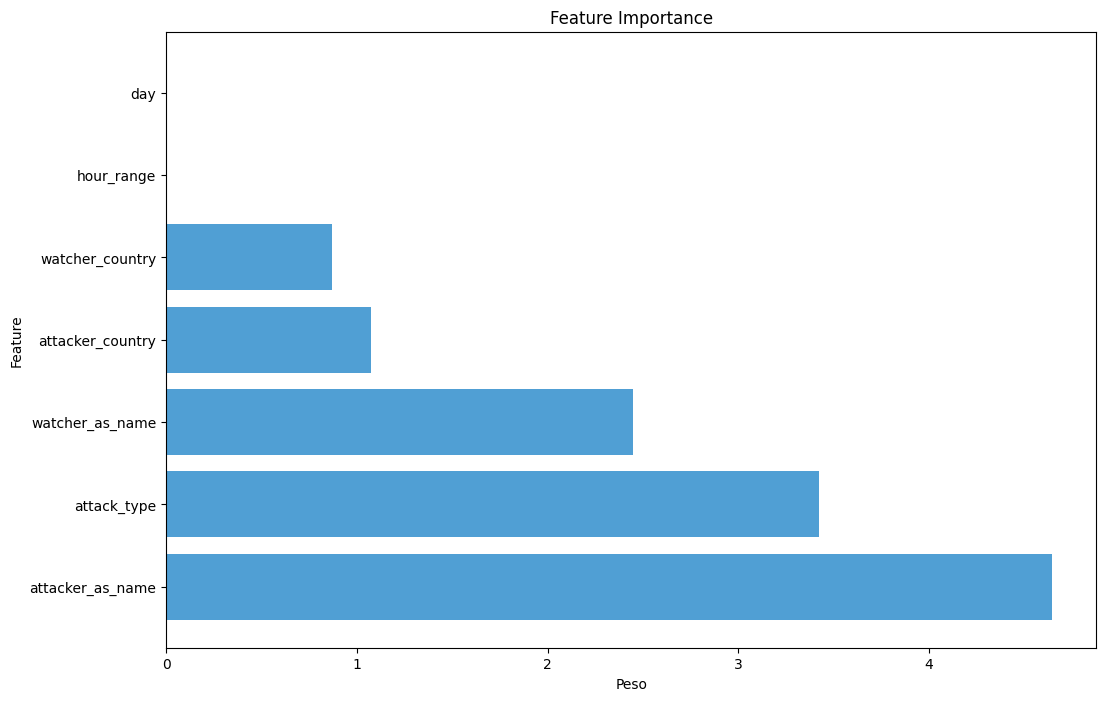

In [ ]:
feature_importance = feature_importance.reindex(feature_importance["coefficient"].sort_values(ascending = False).index)

plt.figure(figsize = (12, 8))
plt.barh(feature_importance["feature"], feature_importance["coefficient"], color = "#509FD4")
plt.title("Feature Importance")
plt.xlabel("Peso")
plt.ylabel("Feature")
plt.show()

Las features más importantes según este baseline son el tipo de ataque y el nombre del atacante.